In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path=untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl=path/'labels'
path_img=path/'images'

In [6]:
fnames=get_image_files(path_img)  #returns images in the file provided
fnames[:3]  # to get first three

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08025.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08107.png')]

In [7]:
lbl_names=get_image_files(path_lbl)  #returns labels

In [13]:
lbl_names[1:4]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03540_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008760_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07991_P.png')]

Show image 

In [14]:
img_file=fnames[0]


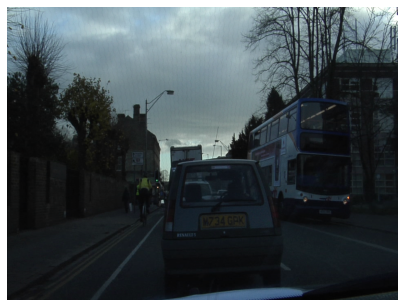

In [15]:
img=open_image(img_file)
img.show(figsize=(7,7))

In [16]:
get_y_fn=lambda x:path_lbl/f'{x.stem}_P{x.suffix}'  # to get the file label

In [17]:
mask=open_mask(get_y_fn(img_file))

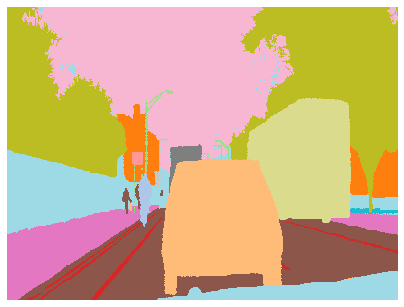

In [18]:
mask.show(figsize=(7,7),alpha=1)  # segmented image

In [19]:
src_size=np.array(mask.shape[1:])

In [20]:
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [22]:
codes=np.loadtxt(path/'codes.txt',dtype=str)  #items
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

DATASETS

In [23]:
size=src_size//2
free=gpu_mem_get_used_no_cache() # the max size of bs depends on the available GPU RAM
if free >8200 :bs=8
else: bs=4
print(bs)

4


In [25]:
src=(SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn,classes=codes))

In [29]:
data=(src.transform(get_transforms(),size=size,tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

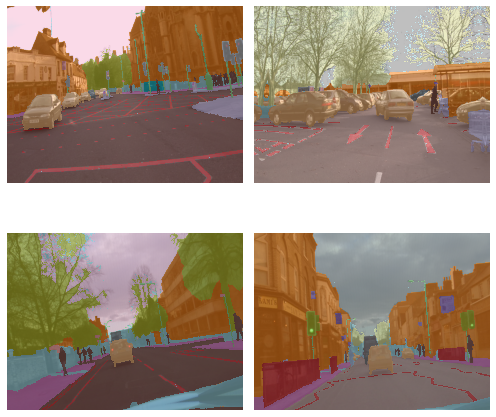

In [30]:
data.show_batch(2,figsize=(7,7))  #show segmented image

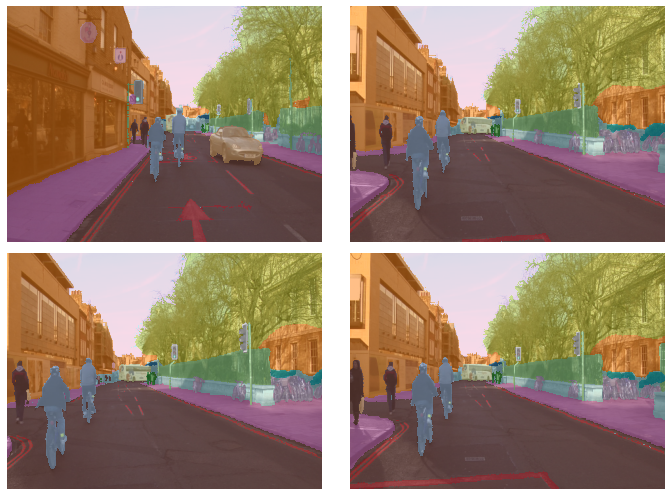

In [31]:

data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [32]:

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [34]:
metric=acc_camvid

In [35]:
wd= 1e-2  #weight decay

In [37]:
learn=unet_learner(data,models.resnet34,metrics=metric,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


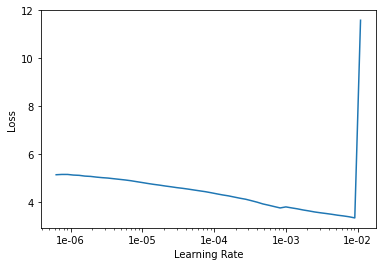

In [39]:
learn.recorder.plot()

In [40]:
 lr=3e-3

In [42]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.036298,0.811676,0.803502,01:28
1,0.751328,0.666105,0.833912,01:27
2,0.670240,0.560587,0.847681,01:27
3,0.625609,0.491215,0.868236,01:26
4,0.589987,0.622379,0.869946,01:26
5,0.620911,0.546443,0.853641,01:26
6,0.559175,0.447319,0.880344,01:25
7,0.536011,0.430616,0.870969,01:25
8,0.519253,0.370201,0.904426,01:25
9,0.430777,0.323721,0.900839,01:25


In [43]:
 learn.save('stage-1')


In [44]:
learn.load('stage-1');

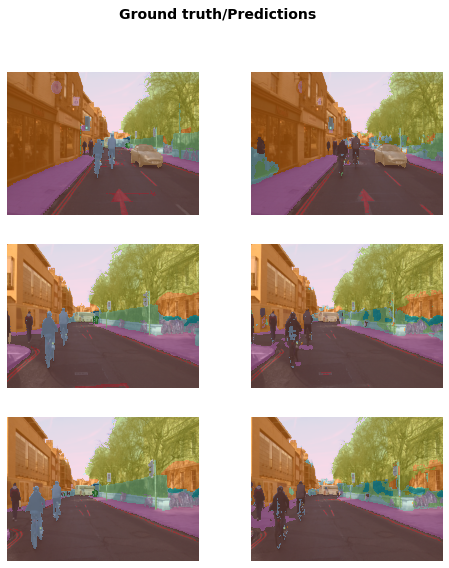

In [45]:
learn.show_results(rows=3, figsize=(8,9))